# Project

### Github Repository : https://github.com/Bo-xuan-Wang/DSI-100-Project

# Introduction

### Background

Video game communities often use newsletters to share updates, foster player engagement, and provide personalized content. However, not every player chooses to subscribe. Understanding which player characteristics are most predictive of newsletter subscription can help developers and researchers better target communication efforts. This project analyzes player data collected from a Minecraft research server hosted by UBC to identify key behavioural and demographic predictors of subscription.

### Question

Can player behaviours (e.g., hours played) and characteristics (e.g., experience level) predict newsletter subscription among players on a Minecraft research server?

# Data Description

The dataset `players.csv` contains 196 observations of player activity from a Minecraft research server. It includes both behavioral and demographic information. For this project, we focused on three variables: `subscribe` (a logical variable indicating whether the player subscribed to the newsletter), `played_hours` (a numeric variable showing how long the player has played), and `experience` (a categorical variable representing the player's self-reported experience level, such as "Beginner", "Pro", or "Veteran"). Other variables such as `name`, `email`, `gender`, and `age` were excluded from analysis. No missing values were present in the variables used. The dataset allows for exploration of how player behavior and self-identified experience relate to subscription status.


# Methods & Results


In [96]:
library(tidyverse)
library(tidymodels)
library(tune)

In [73]:
players <- read_csv("players.csv") 
head(players)
tail(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [74]:
players |> 
  select(subscribe,played_hours,experience) |>
  group_by(experience) |> 
  summarize(subscription_rate = mean(subscribe == "yes"))

experience,subscription_rate
<chr>,<dbl>
Amateur,0
Beginner,0
Pro,0
Regular,0
Veteran,0


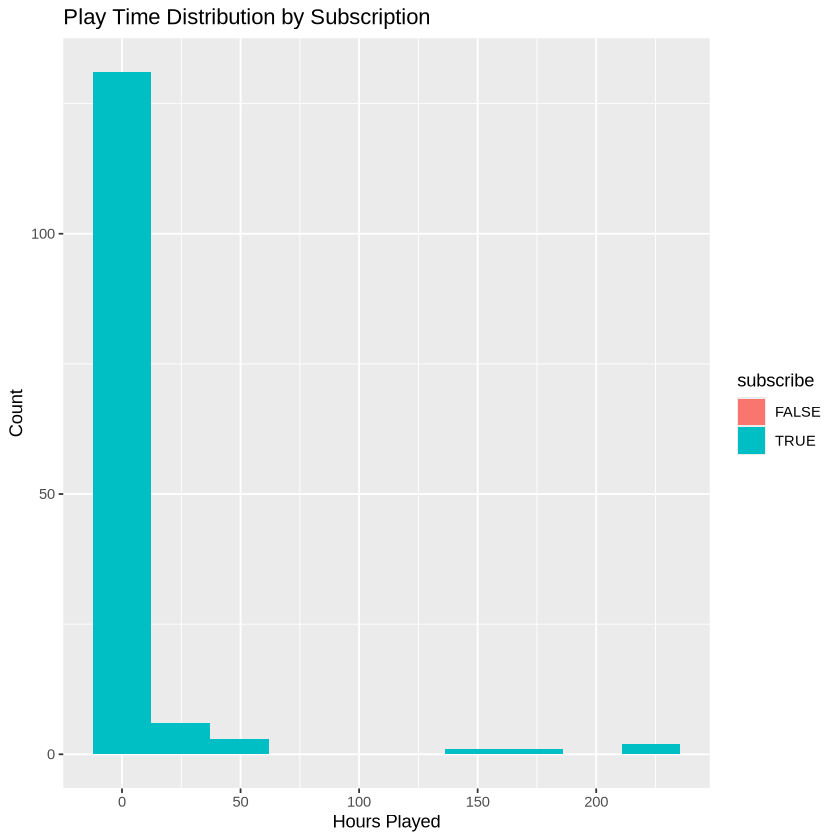

In [75]:
ggplot(players, aes(x = played_hours, fill = subscribe)) + 
  geom_histogram(position = "identity", alpha = 2, bins = 10) +
  labs(title = "Play Time Distribution by Subscription", x = "Hours Played", y = "Count")

In [76]:
library(tidymodels)

In [77]:
set.seed(100)
players <- players |> mutate(subscribe = as_factor(subscribe))

In [78]:
data_split <- initial_split(players, prop = 0.75, strata = subscribe)
data_train <- training(data_split)
data_test <- testing(data_split)

In [79]:
my_recipe <- recipe(subscribe ~ played_hours + experience, data = data_train) |>
  step_center(played_hours) |>
  step_scale(played_hours)

In [80]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [81]:
k_value <- tibble (neighbors = seq(from = 1, to = 30, by =1))

In [82]:
knn_fit <- workflow() |>
  add_recipe(my_recipe) |>
  add_model(knn_spec) |>
  fit(data = data_train)

Warning message:
“tune samples were requested but there were 147 rows in the data. 142 will be used.”


In [83]:
data_pred <- predict(knn_fit, data_test) |>
  bind_cols(data_test)

metrics(data_pred, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.0000000


In [84]:
conf_mat(data_pred, truth = subscribe, estimate = .pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

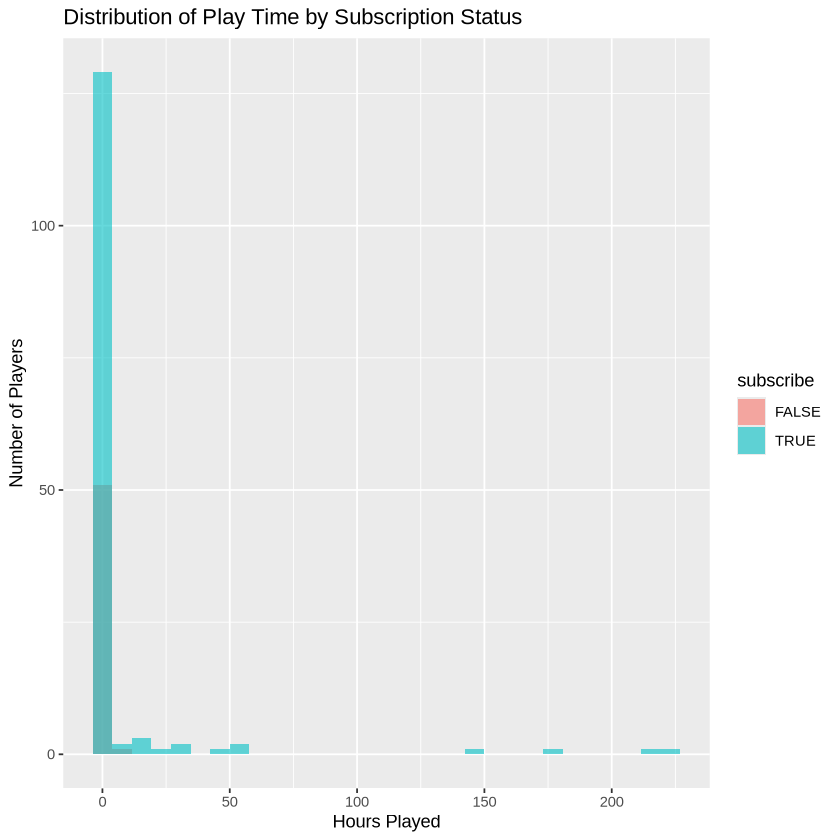

In [85]:
ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "identity", alpha = 0.6, bins = 30) +
  labs(title = "Distribution of Play Time by Subscription Status",
       x = "Hours Played",
       y = "Number of Players")

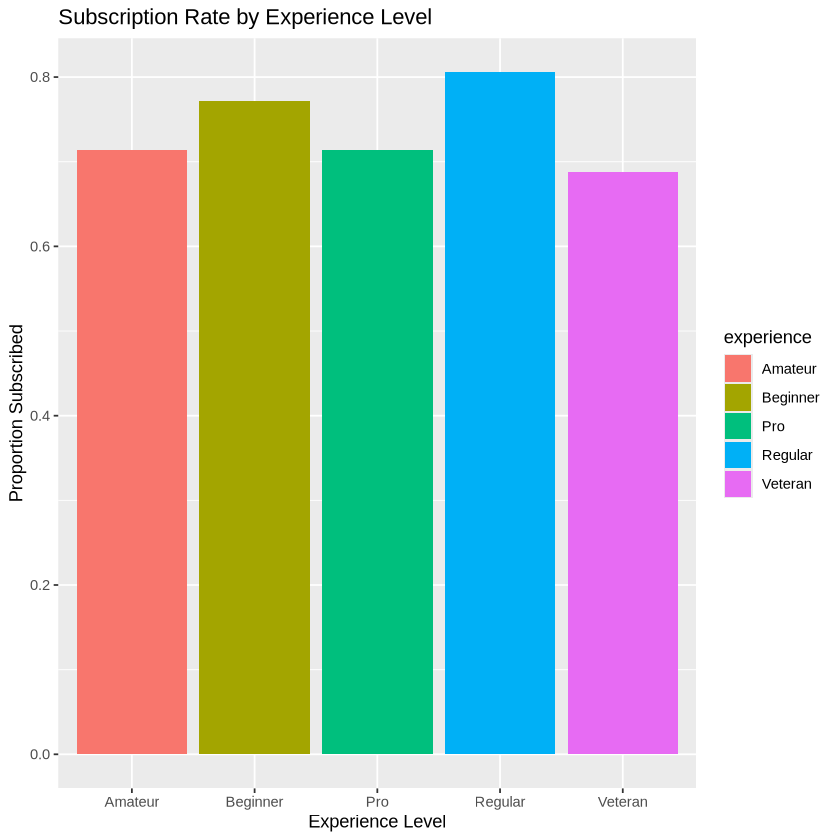

In [95]:
players |>  group_by(experience) |>
  summarize(subscription_rate = mean(subscribe == "TRUE")) |>
  ggplot(aes(x =experience,
             y = subscription_rate, 
             fill = experience)) +
  geom_bar(stat = "identity")+
  labs(title = "Subscription Rate by Experience Level",
       x = "Experience Level",
       y = "Proportion Subscribed") 